<a href="https://colab.research.google.com/github/elemnurguner/data-ai-projects/blob/main/musterianalizi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install faker  # Sahte veri üretmek için
import pandas as pd
import numpy as np
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00


3. Sentetik Veri Üretme
Restoran sipariş verisi oluşturalım:

In [8]:
# DÜZELTİLMİŞ SENTETİK VERİ ÜRETİMİ
fake = Faker()

# 200 benzersiz müşteri oluştur
unique_customers = [{
    "customer_id": fake.uuid4(),
    "customer_name": fake.name(),
    "age": np.random.randint(18, 70),
    "gender": np.random.choice(["Erkek", "Kadın"], p=[0.6, 0.4]),
    "location": fake.city()
} for _ in range(200)]

# 1000 sipariş için müşterileri rastgele seç (tekrarlı)
orders = []
for _ in range(1000):
    customer = np.random.choice(unique_customers)
    orders.append({
        "customer_id": customer["customer_id"],
        "customer_name": customer["customer_name"],
        "age": customer["age"],
        "gender": customer["gender"],
        "order_date": fake.date_between(start_date="-1y", end_date="today"),
        "item_ordered": np.random.choice(["Pizza", "Burger", "Salata", "Makarna", "Köfte"]),
        "order_amount": np.round(np.random.uniform(15, 200), 2),
        "location": customer["location"]
    })

df = pd.DataFrame(orders)
df["order_date"] = pd.to_datetime(df["order_date"])

4. Keşifsel Veri Analizi (EDA)
Temel İstatistikler:

In [9]:
print("Sipariş Miktarı Ortalaması:", df["order_amount"].mean())
print("Toplam Müşteri Sayısı:", df["customer_id"].nunique())
print("Cinsiyet Dağılımı:\n", df["gender"].value_counts())

Sipariş Miktarı Ortalaması: 107.65431
Toplam Müşteri Sayısı: 198
Cinsiyet Dağılımı:
 gender
Erkek    606
Kadın    394
Name: count, dtype: int64


Görselleştirmeler:


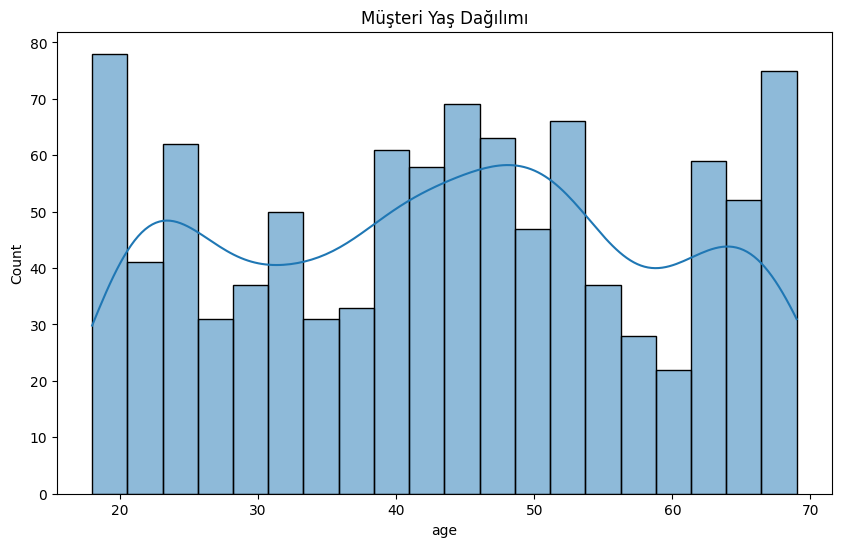

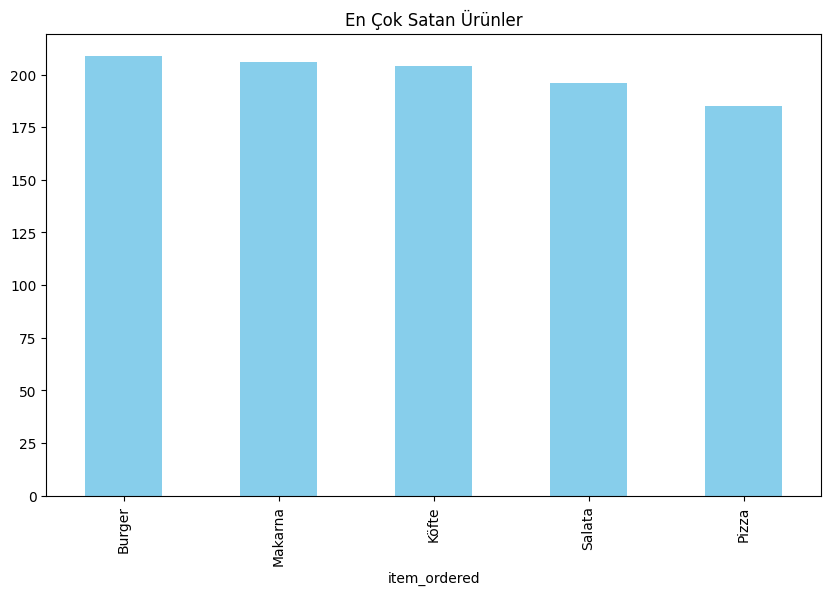

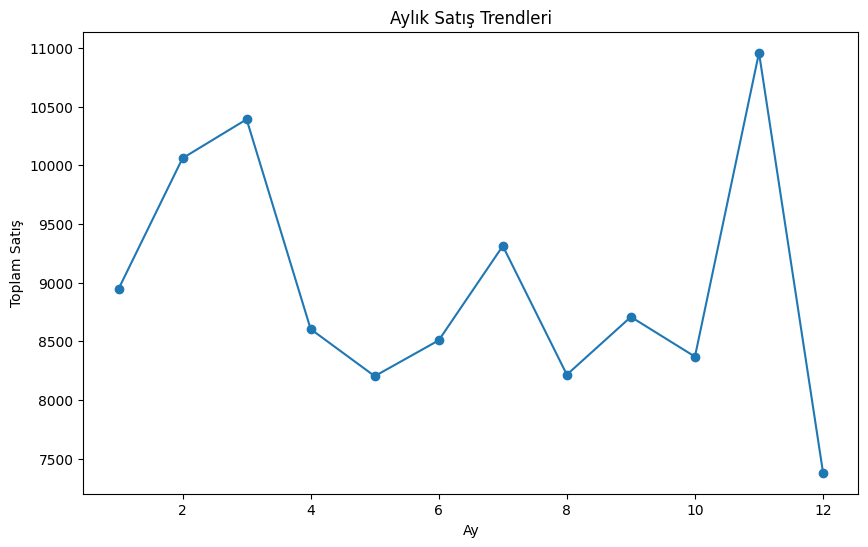

In [10]:
# Yaş Dağılımı
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=20, kde=True)
plt.title("Müşteri Yaş Dağılımı")
plt.show()

# En Popüler Ürünler
plt.figure(figsize=(10, 6))
df["item_ordered"].value_counts().plot(kind="bar", color="skyblue")
plt.title("En Çok Satan Ürünler")
plt.show()

# Aylık Satış Trendleri
df["order_month"] = pd.to_datetime(df["order_date"]).dt.month
monthly_sales = df.groupby("order_month")["order_amount"].sum()
plt.figure(figsize=(10, 6))
monthly_sales.plot(marker="o")
plt.title("Aylık Satış Trendleri")
plt.xlabel("Ay")
plt.ylabel("Toplam Satış")
plt.show()

5. Müşteri Segmentasyonu
RFM Analizi:

In [11]:
#RFM Analizi (düzeltilmiş)
snapshot_date = df["order_date"].max() + pd.DateOffset(days=1)

rfm = df.groupby("customer_id").agg({
    "order_date": lambda x: (snapshot_date - x.max()).days,
    "customer_id": "count",
    "order_amount": "sum"
}).rename(columns={
    "order_date": "Recency",
    "customer_id": "Frequency",
    "order_amount": "Monetary"
})

# RFM skorlaması
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4, 3, 2, 1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 4, labels=[1, 2, 3, 4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1, 2, 3, 4])
rfm["RFM_Score"] = rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)

# Segmentasyon
segments = {
    "Platinum": rfm[rfm["RFM_Score"].isin(["444", "443", "434"])],
    "Gold": rfm[rfm["RFM_Score"].isin(["334", "333", "344"])],
    "Silver": rfm[rfm["RFM_Score"].isin(["234", "223", "224"])],
    "Bronze": rfm[rfm["RFM_Score"].isin(["111", "112", "113"])]
}

for segment, data in segments.items():
    print(f"{segment} Segmenti: {len(data)} müşteri")


Platinum Segmenti: 19 müşteri
Gold Segmenti: 16 müşteri
Silver Segmenti: 12 müşteri
Bronze Segmenti: 29 müşteri


Platinum Müşteriler (En Sadık ve Karlı):


In [12]:
platinum_customers = segments["Platinum"].index
df_platinum = df[df["customer_id"].isin(platinum_customers)]
print("Platinum Müşterilerin En Çok Sipariş Ettiği Ürünler:")
print(df_platinum["item_ordered"].value_counts().head(3))

Platinum Müşterilerin En Çok Sipariş Ettiği Ürünler:
item_ordered
Pizza      35
Burger     32
Makarna    30
Name: count, dtype: int64


Bronze Müşteriler (Az Sipariş Verenler):


In [13]:
bronze_customers = segments["Bronze"].index
df_bronze = df[df["customer_id"].isin(bronze_customers)]
print("Bronze Müşterilerin Son Sipariş Tarihleri:")
print(df_bronze.groupby("customer_id")["order_date"].max().sort_values())

Bronze Müşterilerin Son Sipariş Tarihleri:
customer_id
d5cfba12-ff86-46f9-ae03-7a31fe4211f2   2024-07-01
03396608-da0d-4e3e-ba70-c8339b78e806   2024-07-15
87bfa678-b982-4ee0-a806-7969c0e3659c   2024-07-15
b1f596ce-fb1b-4816-8107-c53a785e5195   2024-07-22
7e9182df-fe16-49b7-8cf1-6c962a4fe23f   2024-09-13
933de9f3-b2f7-481e-bdd5-8a1872acc305   2024-10-18
c3927f28-d0f9-43be-b893-353813fbe63f   2024-11-07
c0a55724-ad47-465c-a0b0-2dba1706988b   2024-11-10
325f41f7-bb53-4293-a0f0-7eaf4635b37d   2024-11-10
929c6e76-9832-48a4-bb6a-ce4ce9d153bd   2024-11-13
27f3ebda-b31f-4ae5-b878-bd32c36355a3   2024-11-14
a422cb70-309b-41b7-b089-81a4f7187459   2024-11-18
48eefb8c-120d-4747-8c6f-9610f980473a   2024-11-22
116a726e-49f0-410b-aacc-dfb10cc90bfa   2024-11-30
dba3c175-8932-48ba-aedb-fea70e6337ed   2024-12-03
d71f8787-bec8-405b-b72b-9d0b5a9433c5   2024-12-20
73faaa8b-2c6f-49a2-8278-8658903f93b2   2024-12-23
a6936d00-462a-4b93-bc1d-0d54b95e44e0   2024-12-31
e5665ce3-5a08-4e7f-884e-c9bb4eef2b84   2025-0

2. Demografik Analiz
Cinsiyet ve Yaş Bazlı Satışlar:

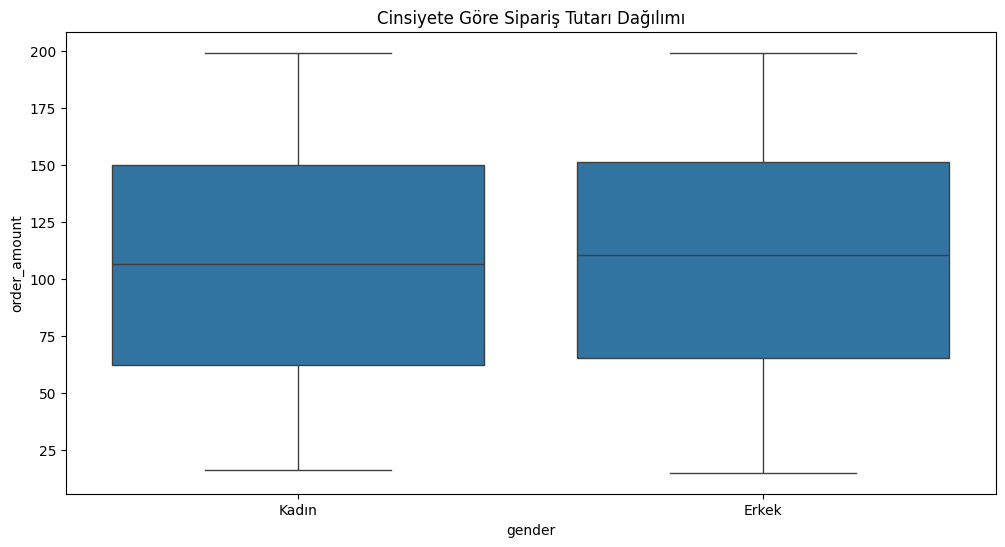

In [14]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="gender", y="order_amount", data=df)
plt.title("Cinsiyete Göre Sipariş Tutarı Dağılımı")
plt.show()

Lokasyon Bazlı Karlılık:


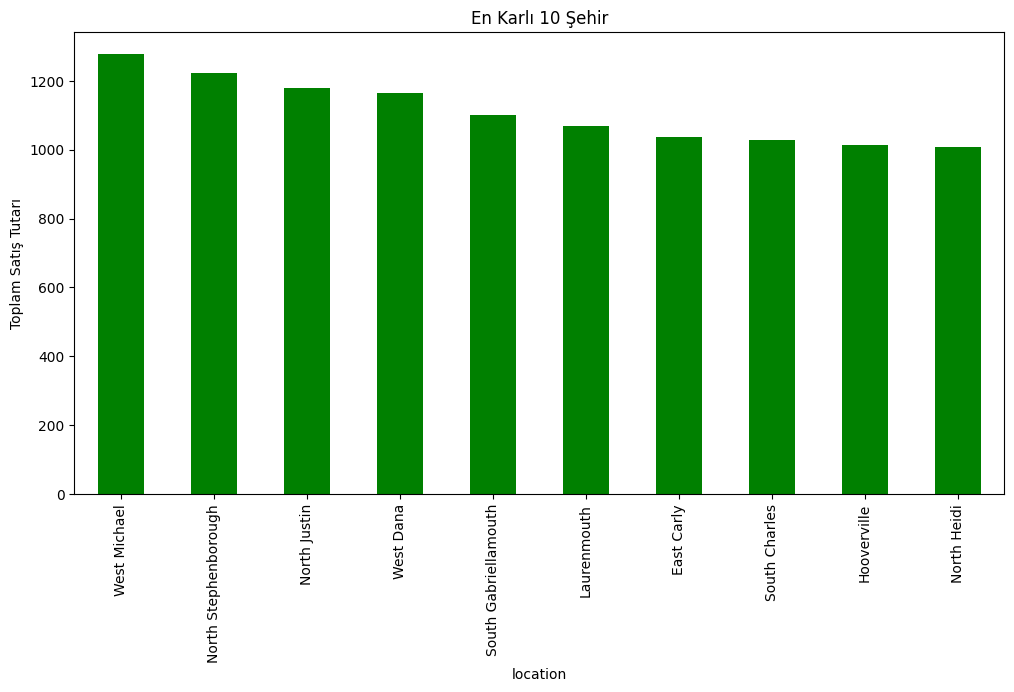

In [15]:
location_profit = df.groupby("location")["order_amount"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
location_profit.plot(kind="bar", color="green")
plt.title("En Karlı 10 Şehir")
plt.ylabel("Toplam Satış Tutarı")
plt.show()

3. Ürün Performans Analizi
En Popüler Ürünler ve Cinsiyet İlişkisi:

<Figure size 1200x600 with 0 Axes>

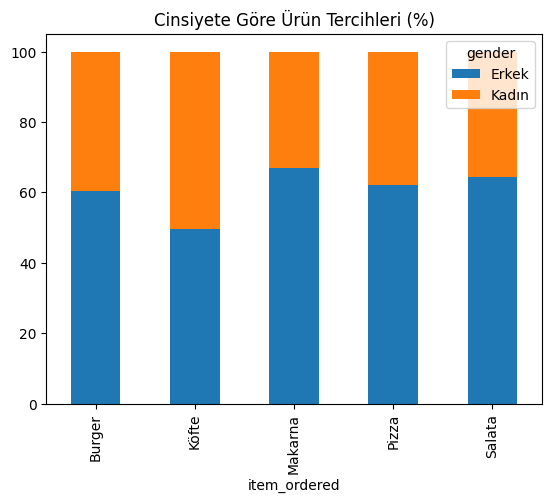

In [16]:
cross_tab = pd.crosstab(df["item_ordered"], df["gender"], normalize="index") * 100
plt.figure(figsize=(12, 6))
cross_tab.plot(kind="bar", stacked=True)
plt.title("Cinsiyete Göre Ürün Tercihleri (%)")
plt.show()

Ürün Başına Ortalama Sipariş Tutarı:


In [17]:
product_avg = df.groupby("item_ordered")["order_amount"].mean().sort_values(ascending=False)
print("Ürün Başına Ortalama Kazanç:\n", product_avg)

Ürün Başına Ortalama Kazanç:
 item_ordered
Pizza      114.620541
Köfte      107.860196
Makarna    107.029806
Salata     104.691786
Burger     104.680861
Name: order_amount, dtype: float64


4. Zaman Serisi Analizi
Aylık Satış Trendleri:

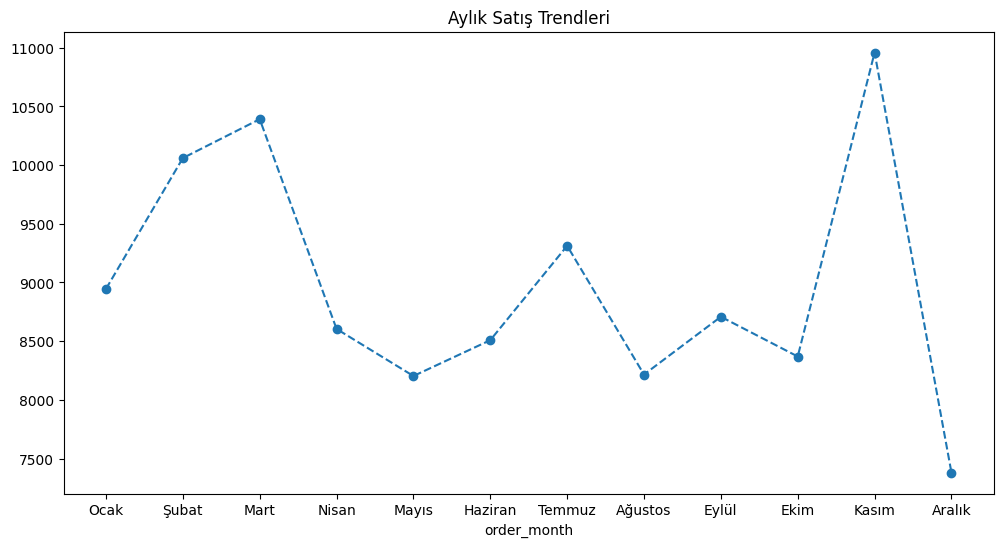

In [18]:
df["order_month"] = df["order_date"].dt.month
monthly_sales = df.groupby("order_month")["order_amount"].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker="o", linestyle="--")
plt.title("Aylık Satış Trendleri")
plt.xticks(range(1, 13), ["Ocak", "Şubat", "Mart", "Nisan", "Mayıs", "Haziran",
                          "Temmuz", "Ağustos", "Eylül", "Ekim", "Kasım", "Aralık"])
plt.show()

5. Müşteri Yaşam Boyu Değeri (CLV) Tahmini


In [19]:
# Basit CLV Hesaplama (Ortalama Sipariş Değeri * Sipariş Sıklığı * Müşteri Ömrü)
avg_order_value = df["order_amount"].mean()
purchase_frequency = df["customer_id"].nunique() / df.shape[0]
clv = avg_order_value * purchase_frequency * 12  # 12 aylık tahmini ömür
print("Ortalama CLV (Basit Model):", np.round(clv, 2))

Ortalama CLV (Basit Model): 255.79


6. Kayıp Müşteri Analizi
Son 3 Aydır Sipariş Vermeyenler:

In [20]:
last_order_date = df["order_date"].max()
cutoff_date = last_order_date - pd.DateOffset(months=3)
lost_customers = df[df["order_date"] < cutoff_date]["customer_id"].unique()
print("Kayıp Müşteri Sayısı:", len(lost_customers))

Kayıp Müşteri Sayısı: 191



7. Makine Öğrenmesi ile Kümeleme (Customer Segmentation)
K-Means ile Müşteri Segmentasyonu:

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Veriyi Ölçeklendirme
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])

# K-Means Modeli
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)

# Küme Analizi
print(rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean())

            Recency  Frequency    Monetary
Cluster                                   
0         35.390244   4.121951  427.083659
1        112.625000   5.625000  640.353438
2         29.254545   7.454545  826.984727
3        143.344828   2.482759  229.585517


8. Müşteri Geri Bildirim Simülasyonu (Sentetik Veriye Ek)


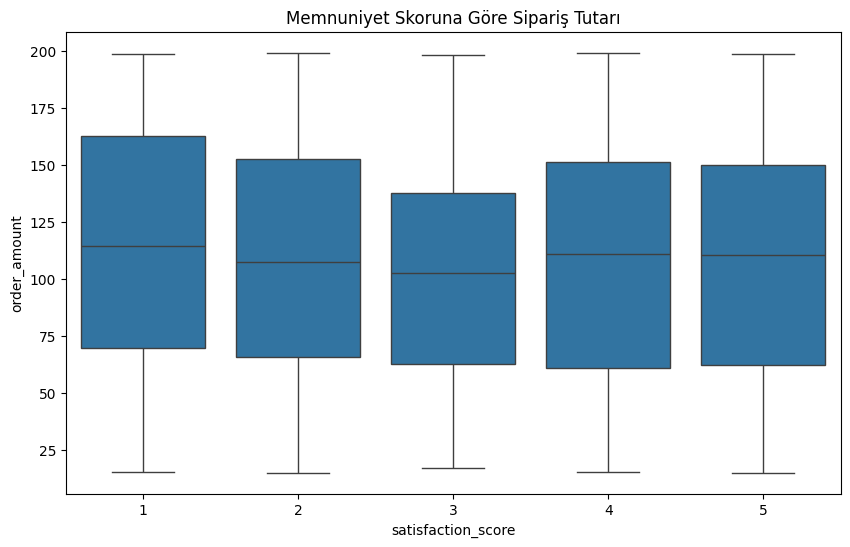

In [22]:
# Sentetik Memnuniyet Skoru Ekleme
np.random.seed(42)
df["satisfaction_score"] = np.random.randint(1, 6, df.shape[0])

# Memnuniyet vs. Sipariş Tutarı İlişkisi
plt.figure(figsize=(10, 6))
sns.boxplot(x="satisfaction_score", y="order_amount", data=df)
plt.title("Memnuniyet Skoruna Göre Sipariş Tutarı")
plt.show()

9. Raporlama ve Dashboard
Matplotlib ile Özet Rapor:

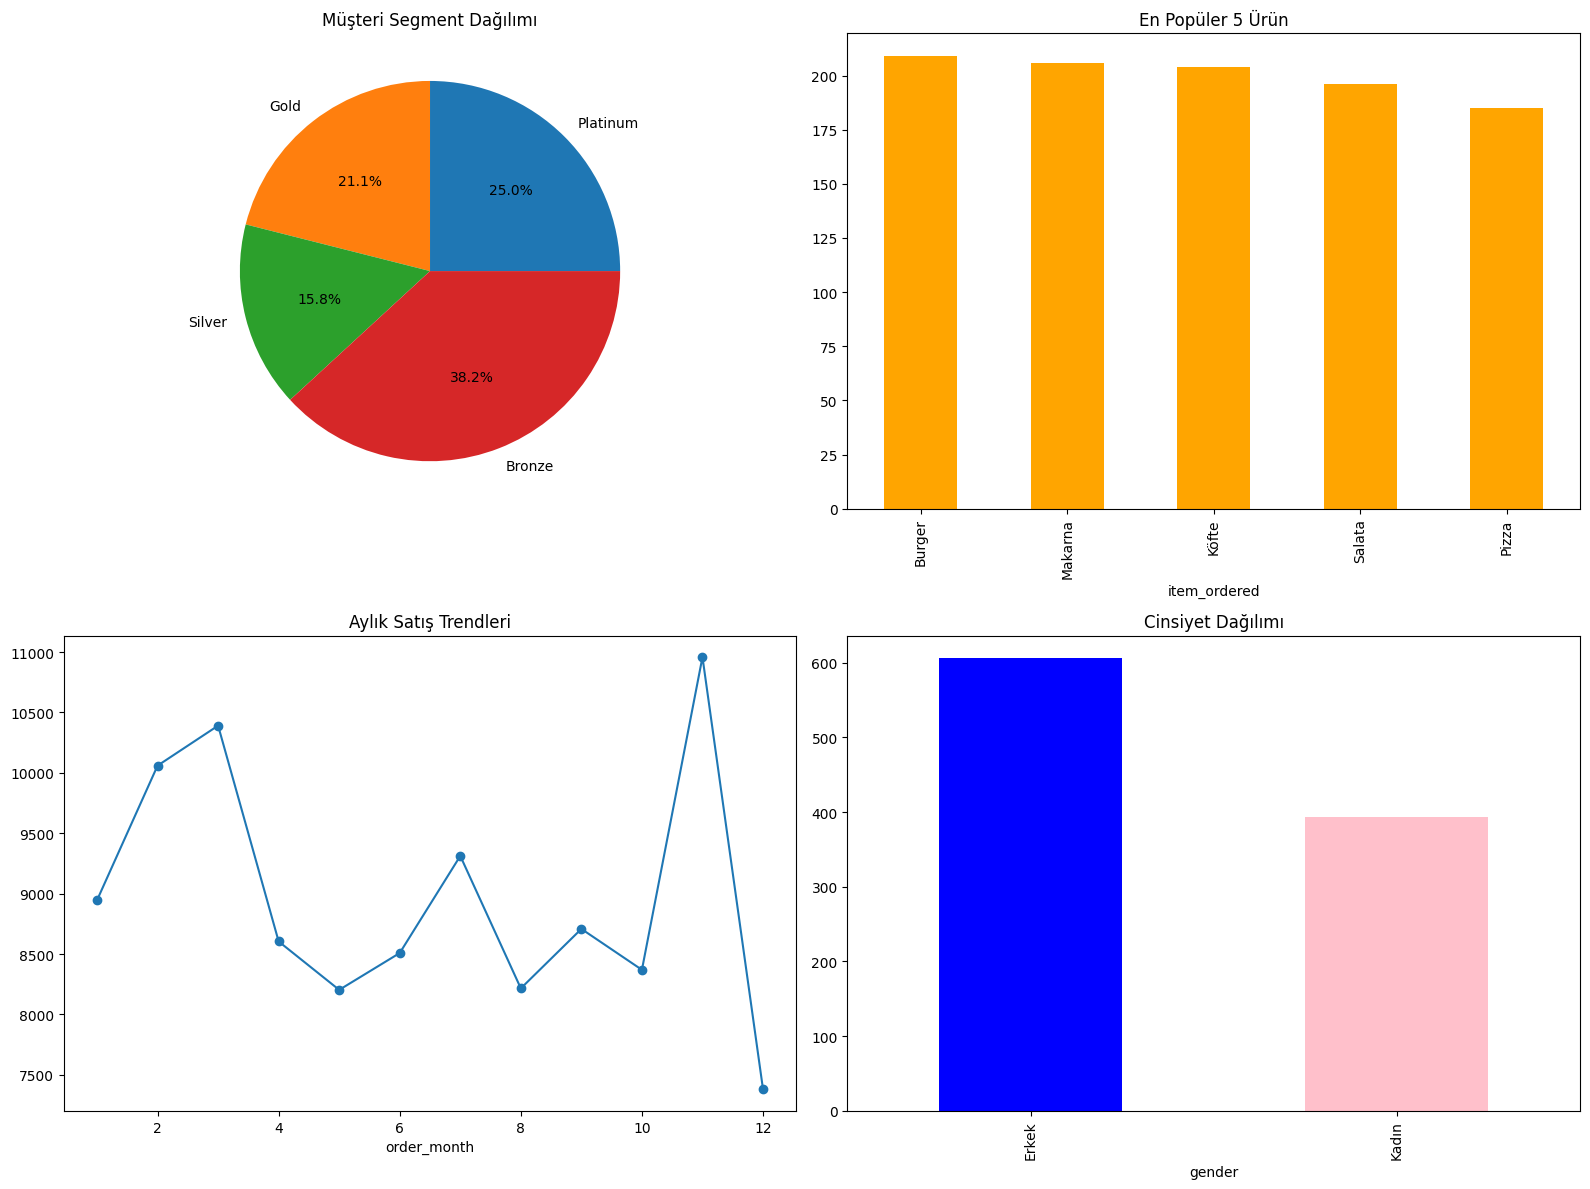

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Segment Dağılımı
segments_counts = pd.Series({k: len(v) for k, v in segments.items()})
segments_counts.plot(kind="pie", autopct="%1.1f%%", ax=axes[0, 0])
axes[0, 0].set_title("Müşteri Segment Dağılımı")

# En Popüler Ürünler
df["item_ordered"].value_counts().head(5).plot(kind="bar", ax=axes[0, 1], color="orange")
axes[0, 1].set_title("En Popüler 5 Ürün")

# Aylık Satış Trendleri
monthly_sales.plot(ax=axes[1, 0], marker="o")
axes[1, 0].set_title("Aylık Satış Trendleri")

# Cinsiyet Dağılımı
df["gender"].value_counts().plot(kind="bar", ax=axes[1, 1], color=["blue", "pink"])
axes[1, 1].set_title("Cinsiyet Dağılımı")

plt.tight_layout()
plt.show()